## Sheet 2 | GPs, VAEs, and DDPMs

__Author__: Richard Michael


__Date__: 07-01-2024

### GPs

1.) The variation of the Wiener process at index set $S={x_1,...,x_l}$, $f_0=0, x_0=0$ and $f_{i+1}=f_i+W_i, \text{  } W_i\sim\mathcal{N}(0,\sqrt{x_{i+1}-x_i})$ is not a random process.:

Let $f=(f_T, f_C)$ and from the definition of random processes be $p(f_T|T)=\int p(f_T, f_C|S)df_C=\int p(0, w_1, \ldots, \sum_i w_i, f_C|S)df_C$

$
\Rightarrow W\sim\mathcal{N}\left(0, \begin{bmatrix}
\sqrt{x_1-x_0} & 0 & & \ldots &  0 \\
0 & \sqrt{x_2-x_1}  & 0 & \ldots &  0 \\
0 & \ldots & \ldots & & 0 \\
0 & \ldots & \ldots & &\sqrt{x_C-x_{C-1}}  \\
\end{bmatrix}\right)
$
then by $f\sim \mathcal{N}(0, ADA^T)\Leftrightarrow$


$
f\sim \begin{bmatrix} f_1 \\ . \\ . \\ . \\ f_C \end{bmatrix}\begin{bmatrix}
1 & 0 &\ldots & 0 \\ 
1 & 1 &\ldots & 0 \\
. & . &\ldots & 0 \\
1 & 1 &\ldots & 1 \\
\end{bmatrix}\begin{bmatrix} w_0 \\ . \\ . \\ . \\ w_C \end{bmatrix}
$
Then eventually we get 
$ADA^T=\begin{bmatrix}
\sqrt{x_1-x_0} & \sqrt{x_1-x_0} &\ldots & \sqrt{x_1-x_0} \\ 
\sqrt{x_1-x_0} & \sqrt{x_2-x_1}+\sqrt{x_2-x_1} &\sqrt{x_2-x_1}+\sqrt{x_2-x_1} & \sqrt{x_2-x_1}+\sqrt{x_2-x_1} \\
. & . &\ldots & \ldots \\
\sqrt{x_1-x_0} & \sqrt{x_2-x_1}+\sqrt{x_2-x_1} &\ldots & \sum_i\sqrt{x_i-x_{i-1}} \\
\end{bmatrix}$
From the resulting matrix we can see a dependency on previous iterations through the sum of square-roots. 
This is not a reducible sum - c.f. Wiener Process.
Thus the KCT property is not met and the resulting process is not a random process.


### GP Programming

In [1]:
import numpy as np
import scipy
from scipy import stats as ss
import matplotlib.pyplot as plt
import torch
import inspect

SEED=3012024

In [2]:
from matplotlib import colormaps 
cmap = 'plasma'

In [3]:
### A)
def gauss_kernel(x: float, y: float, gamma: float=1.) -> float:
    return np.exp(-gamma*np.power((x-y), 2))

In [4]:
# points to evaluate
S = np.linspace(0, 1, 101)
print(S[:3])
# in 2D pair of values
XX = np.dstack(np.meshgrid(S, S)).reshape(-1, 2)

cov_matrix = np.array(list(map(lambda x: gauss_kernel(x[0], x[1]), XX))).reshape(S.shape[0], S.shape[0])
# NOTE: to be efficient, compute only upper triangle and mirror, since you should have a symmetric matrix
cov_matrix

[0.   0.01 0.02]


array([[1.        , 0.9999    , 0.99960008, ..., 0.38273976, 0.37527357,
        0.36787944],
       [0.9999    , 1.        , 0.9999    , ..., 0.39027643, 0.38273976,
        0.37527357],
       [0.99960008, 0.9999    , 1.        , ..., 0.39788192, 0.39027643,
        0.38273976],
       ...,
       [0.38273976, 0.39027643, 0.39788192, ..., 1.        , 0.9999    ,
        0.99960008],
       [0.37527357, 0.38273976, 0.39027643, ..., 0.9999    , 1.        ,
        0.9999    ],
       [0.36787944, 0.37527357, 0.38273976, ..., 0.99960008, 0.9999    ,
        1.        ]])

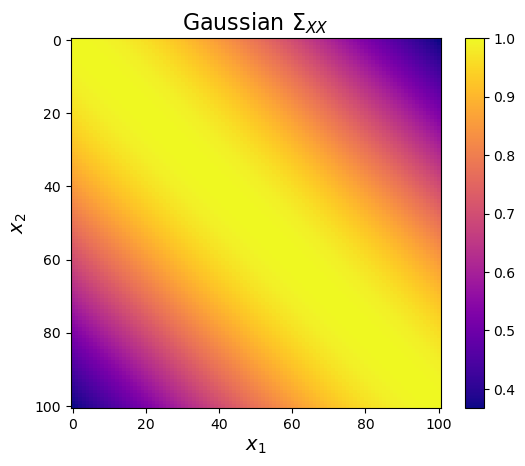

In [5]:
plt.imshow(cov_matrix, cmap=cmap)
plt.title(r"Gaussian $\Sigma_{XX}$", fontsize=16)
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14)
plt.colorbar()
plt.show()

In [6]:
S[-1]

1.0

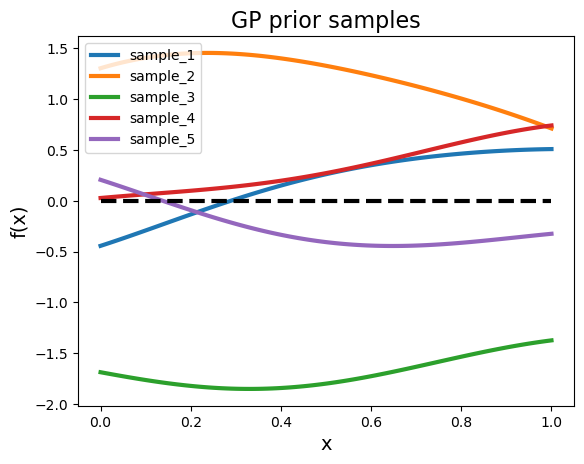

In [7]:
gp_prior_samples = ss.multivariate_normal.rvs(mean=np.zeros(S.shape[0]), cov=cov_matrix, size=5, random_state=SEED)

for i, sample in enumerate(gp_prior_samples):
    plt.plot(S, sample, lw=3., label=f"sample_{i+1}")
plt.hlines(0, S[0], S[-1], lw=3., colors="k", linestyles="dashed")
plt.ylabel("f(x)", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.legend()
plt.title("GP prior samples", fontsize=16)
plt.show()

In [8]:
### USE PROVIDED HINTS:
def ref_gaussian_kernel(X,Xprime, gamma=1):
    dists = scipy.spatial.distance.cdist(X,Xprime,metric='sqeuclidean')
    return np.exp(-gamma*dists)


def special_kernel(X,Xprime, eta):
    a = eta[0]
    b = eta[1]
    K = (1+X@Xprime.T)**2 + a * np.multiply.outer(np.sin(2*np.pi*X.reshape(-1)+b),np.sin(2*np.pi*Xprime.reshape(-1)+b))
    return K

ref_cov = ref_gaussian_kernel(S[:, np.newaxis], S[:, np.newaxis])

# Assess if our implementation is correct:
np.testing.assert_almost_equal(cov_matrix, ref_cov) 

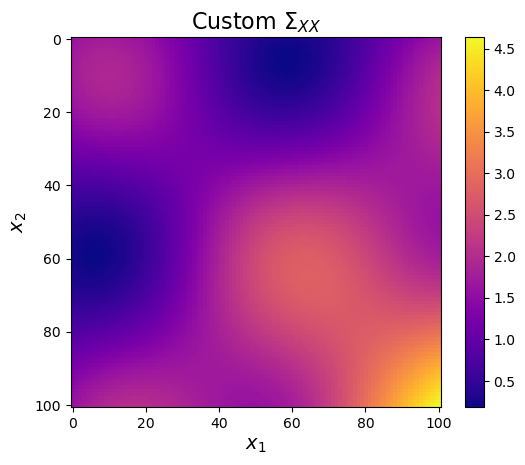

In [9]:
# Sidenote: what does our special kernel look like? Pick arbitrary eta
special_cov_mat = special_kernel(S[:, np.newaxis], S[:, np.newaxis], eta=[0.9, 1.])
plt.imshow(special_cov_mat, cmap=cmap)
plt.title(r"Custom $\Sigma_{XX}$", fontsize=16)
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14)
plt.colorbar()
plt.show()

Looks like we did alright, we can continue...

In [10]:
data = np.loadtxt("./data/co2_mm_mlo.csv", delimiter=",", dtype=float)

# IMPORT preprocessing from provided script:
#10 years of data for learning
X = data[:120,2]-1958
y_raw = data[:120,3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y = (y_raw-y_mean)/y_std
#the next 5 years for prediction
X_predict = data[120:180,2]-1958
y_predict = data[120:180,3]

In [11]:
0.001*np.eye(y.shape[0])+ref_gaussian_kernel(X[:, np.newaxis], X[:, np.newaxis])

array([[1.00100000e+00, 9.92801038e-01, 9.72431308e-01, ...,
        4.84434311e-42, 9.19823952e-43, 1.72500509e-43],
       [9.92801038e-01, 1.00100000e+00, 9.93265936e-01, ...,
        2.52463516e-41, 4.86327955e-42, 9.25269628e-43],
       [9.72431308e-01, 9.93265936e-01, 1.00100000e+00, ...,
        1.22906784e-40, 2.40082782e-41, 4.63177547e-42],
       ...,
       [4.84434311e-42, 2.52463516e-41, 1.22906784e-40, ...,
        1.00100000e+00, 9.92834754e-01, 9.71678539e-01],
       [9.19823952e-43, 4.86327955e-42, 2.40082782e-41, ...,
        9.92834754e-01, 1.00100000e+00, 9.92851582e-01],
       [1.72500509e-43, 9.25269628e-43, 4.63177547e-42, ...,
        9.71678539e-01, 9.92851582e-01, 1.00100000e+00]])

In [12]:
# use function definitions and fill in the blanks
# B) todo: implement this
def negLogLikelihood(params, kernel, S=X, y=y):
    noise_y = params[0]    
    eta = params[1:]
    sigma_y_I = noise_y*np.eye(y.shape[0])
    if "eta" in inspect.signature(kernel).parameters.keys(): # NOTE: this check is not strictly required
        K = kernel(S[:, np.newaxis], S[:, np.newaxis], eta=eta)
    else:
        K = kernel(S[:, np.newaxis], S[:, np.newaxis])
    n = y.shape[0]
    # using lecture notes 6.2
    observed_fit = y.T@scipy.linalg.inv(sigma_y_I+K)@y
    model_complexity = np.log(np.linalg.det(sigma_y_I+K))
    print(f"data fit={np.round(observed_fit,2)}")
    print(f"model complexity={np.round(model_complexity,2)}")
    # print(f"reg. const.={np.round(n/2*np.log(np.sqrt(2*np.pi)),2)} [OMITTED]")
    ll = -1/2*observed_fit - 1/2*model_complexity #- n/2*np.log(np.sqrt(2*np.pi)) # NOTE: we can drop the constant here
    # small HACK to avoid -inf of problematic regions
    if np.isinf(ll):
        return np.inf # NOTE: we optimize by minimization, hence large positive value should be discarded by opt routine
    return -ll # NEGATIVE loglikelihood


def optimize_params(ranges, kernel, Ngrid):
    opt_params = scipy.optimize.brute(lambda params: negLogLikelihood(params, kernel), ranges, Ns=Ngrid, finish=None)
    noise_var = opt_params[0]
    eta = opt_params[1:]
    nll = negLogLikelihood(opt_params, kernel) # NOTE: added
    print(f"optimized NLL={nll}")
    return noise_var, eta

In [13]:
# B) todo: implement the posterior distribution, i.e. the distribution of f^star
def conditional(X, x_star, y, noise_var, kernel):
    # See eq. 66 in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)
    sigma_I = noise_var*np.eye(y.shape[0])
    mu_star = kernel(X, x_star).T @ scipy.linalg.inv( kernel(X, X)+sigma_I) @ y
    sigma_star = kernel(x_star, x_star) - kernel(X, x_star).T @ scipy.linalg.inv( kernel(X,X)+sigma_I ) @ kernel(X, x_star)
    return mu_star, sigma_star # return mean and covariance matrix

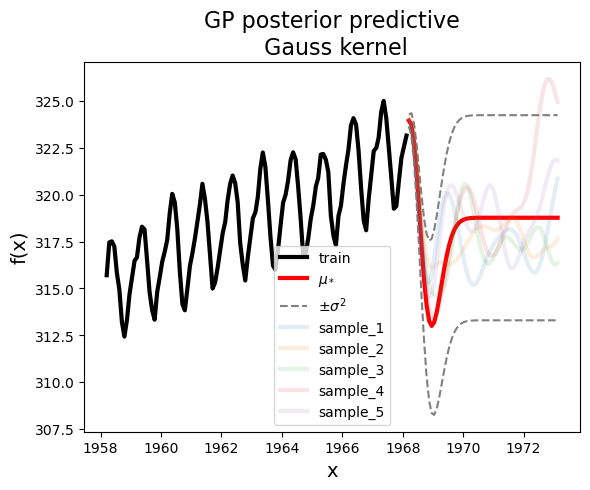

In [14]:
pred_mu_gauss, pred_cov_gauss = conditional(X[:, np.newaxis], X_predict[:, np.newaxis], y, 0.001, lambda x,y: ref_gaussian_kernel(x, y, gamma=2))
pred_var_gauss = np.diag(pred_cov_gauss)

# rescale 
t_adjust = 1958
pred_mu = pred_mu_gauss*y_std + y_mean
pred_var =pred_var_gauss*y_std**2

# sample posterior dist:
gp_gauss_post_samples = ss.multivariate_normal.rvs(mean=pred_mu_gauss, cov=pred_cov_gauss, size=5)


# visualize
plt.plot(X + t_adjust, y*y_std + y_mean, c="k", lw=3., label="train")
plt.plot(X_predict + t_adjust, pred_mu, c="r", lw=3., label=r"$\mu_*$")
plt.plot(X_predict + t_adjust, pred_mu+1.96*pred_var**0.5, color='grey', linestyle="dashed", label=r"$\pm \sigma^2$")
plt.plot(X_predict + t_adjust, pred_mu-1.96*pred_var**0.5, color='grey', linestyle="dashed")
for i, sample in enumerate(gp_gauss_post_samples):
    plt.plot(X_predict + t_adjust, sample*y_std + y_mean, lw=3., alpha=0.125, label=f"sample_{i+1}")
# plt.hlines(0, X[0], X_predict[-1], lw=3., colors="k", linestyles="dashed")
plt.ylabel("f(x)", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.legend()
plt.title("GP posterior predictive\n Gauss kernel", fontsize=16)
plt.show()

/Users/rcml/miniforge3/envs/pml22/lib/python3.11/site-packages/scipy/stats/_multivariate.py:681: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


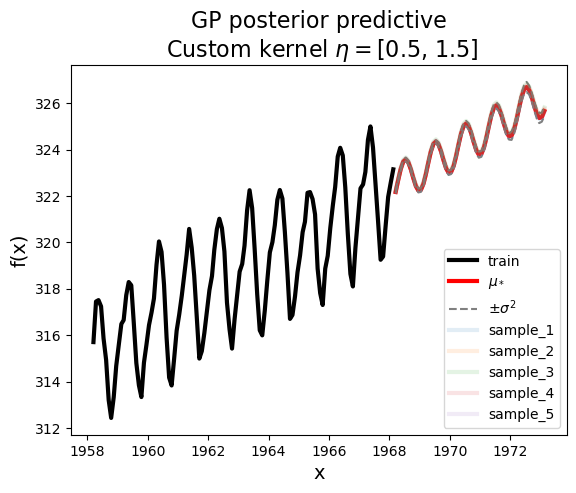

In [15]:
some_eta = [0.5, 1.5]
pred_mu_spec, pred_cov_spec = conditional(X[:, np.newaxis], X_predict[:, np.newaxis], y, 0.001, lambda x, y: special_kernel(x, y, eta=some_eta))
pred_var_spec = np.diag(pred_cov_spec)

# sample posterior dist:
gp_spec_post_samples = ss.multivariate_normal.rvs(mean=pred_mu_spec, cov=pred_cov_spec, size=5)

# rescale 
t_adjust = 1958
pred_mu_spec = pred_mu_spec*y_std + y_mean
pred_var_spec =pred_var_spec*y_std**2


# visualize
plt.plot(X + t_adjust, y*y_std + y_mean, c="k", lw=3., label="train")
plt.plot(X_predict + t_adjust, pred_mu_spec, c="r", lw=3., label=r"$\mu_*$")
plt.plot(X_predict + t_adjust, pred_mu_spec+1.96*pred_var_spec**0.5, color='grey', linestyle="dashed", label=r"$\pm \sigma^2$")
plt.plot(X_predict + t_adjust, pred_mu_spec-1.96*pred_var_spec**0.5, color='grey', linestyle="dashed")
for i, sample in enumerate(gp_spec_post_samples):
    plt.plot(X_predict + t_adjust, sample*y_std + y_mean, lw=3., alpha=0.125, label=f"sample_{i+1}")
# plt.hlines(0, X[0], X_predict[-1], lw=3., colors="k", linestyles="dashed")
plt.ylabel("f(x)", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.legend()
plt.title(f"GP posterior predictive\n Custom kernel " + r"$\eta=$" + f"{str(some_eta)}", fontsize=16)
plt.show()

In [16]:
# C)
# kernel = ref_gaussian_kernel # TODO: change to new kernel
kernel = special_kernel
ranges = ((1.e-4,10), (1.e-4,10), (0.00001, 2.*np.pi)) # TODO: add new parameters
Ngrid = 10
noise_var, eta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)

/var/folders/7n/r4gz04v155x34_3hgrpy2t900000gn/T/ipykernel_1388/2654247314.py:14: RuntimeWarning: divide by zero encountered in log
  model_complexity = np.log(np.linalg.det(sigma_y_I+K))


data fit=148314.45
model complexity=-inf
data fit=462783.48
model complexity=-inf
data fit=530286.17
model complexity=-inf
data fit=235839.84
model complexity=-inf
data fit=68757.85
model complexity=-inf
data fit=303559.14
model complexity=-inf
data fit=552539.18
model complexity=-inf
data fit=405169.57
model complexity=-inf
data fit=102853.38
model complexity=-inf
data fit=148310.79
model complexity=-inf
data fit=141495.89
model complexity=-inf
data fit=461195.56
model complexity=-inf
data fit=529816.24
model complexity=-inf
data fit=230412.1
model complexity=-inf
data fit=60581.07
model complexity=-inf
data fit=299330.35
model complexity=-inf
data fit=552442.94
model complexity=-inf
data fit=402592.58
model complexity=-inf
data fit=95209.88
model complexity=-inf
data fit=141492.18
model complexity=-inf
data fit=141495.58
model complexity=-inf
data fit=461195.48
model complexity=-inf
data fit=529816.21
model complexity=-inf
data fit=230411.85
model complexity=-inf
data fit=60580.69
mo

In [17]:
# before hack: optimal params: 0.0001 [1.e-04 1.e-05]
# after hack (inf check): optimal params: 1.1112 [1.1112     2.79253236]

/var/folders/7n/r4gz04v155x34_3hgrpy2t900000gn/T/ipykernel_1388/1381514879.py:17: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(X_predict + t_adjust, pred_mu_spec+1.96*pred_var_spec**0.5, color='grey', linestyle="dashed", label=r"$\pm \sigma^2$")
/var/folders/7n/r4gz04v155x34_3hgrpy2t900000gn/T/ipykernel_1388/1381514879.py:18: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(X_predict + t_adjust, pred_mu_spec-1.96*pred_var_spec**0.5, color='grey', linestyle="dashed")


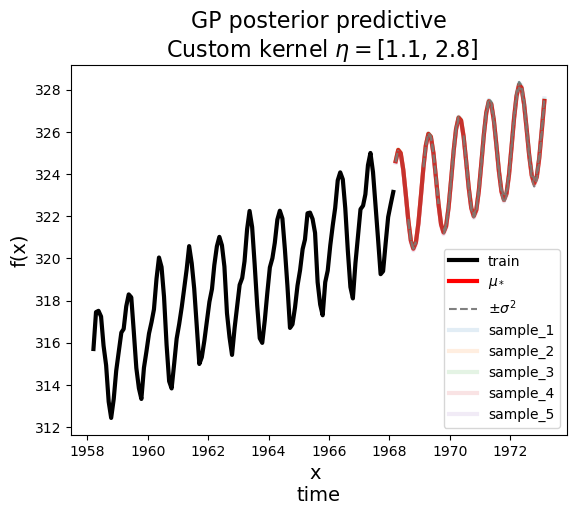

In [18]:
# use optimized parameters:
some_eta = [1.1, 2.8]
pred_mu_spec, pred_cov_spec = conditional(X[:, np.newaxis], X_predict[:, np.newaxis], y, 0.001, lambda x, y: special_kernel(x, y, eta=some_eta))
pred_var_spec = np.diag(pred_cov_spec)

# sample posterior dist:
gp_spec_post_samples = ss.multivariate_normal.rvs(mean=pred_mu_spec, cov=pred_cov_spec, size=5)

# rescale 
t_adjust = 1958
pred_mu_spec = pred_mu_spec*y_std + y_mean
pred_var_spec =pred_var_spec*y_std**2

# visualize
plt.plot(X + t_adjust, y*y_std + y_mean, c="k", lw=3., label="train")
plt.plot(X_predict + t_adjust, pred_mu_spec, c="r", lw=3., label=r"$\mu_*$")
plt.plot(X_predict + t_adjust, pred_mu_spec+1.96*pred_var_spec**0.5, color='grey', linestyle="dashed", label=r"$\pm \sigma^2$")
plt.plot(X_predict + t_adjust, pred_mu_spec-1.96*pred_var_spec**0.5, color='grey', linestyle="dashed")
for i, sample in enumerate(gp_spec_post_samples):
    plt.plot(X_predict + t_adjust, sample*y_std + y_mean, lw=3., alpha=0.125, label=f"sample_{i+1}")
# plt.hlines(0, X[0], X_predict[-1], lw=3., colors="k", linestyles="dashed")
plt.ylabel("f(x)", fontsize=14)
plt.xlabel("x \ntime", fontsize=14)
plt.legend()
plt.title(f"GP posterior predictive\n Custom kernel " + r"$\eta=$" + f"{str(some_eta)}", fontsize=16)
plt.show()

#### Discussion

Our initial observation is that the training data shows an upward trend and the values appear to follow cyclical trend across time.


The standard Gaussian kernel specifies an insufficient GP model, this is because at an increasing distance away from the training data we revert back to the prior mean, 
which is the zero-mean (plus standardization adjustment). 
This makes renders any extrapolation with the posterior predictive insufficient.
The model does not capture the cyclical nature of the observations and the upward trend across time.


The shortcomings of the Gaussian kernel are addressed by the custom kernel function, which has periodic elements (sin function), that make it suitable to capture the cycles in our observations.
Further, the posterior predictive captures an upward trend (the covariance function includes additive adjustments).
After evaluating the posterior predictive, we can see that an extrapolation with this covariance function appears more suitable.
The posterior predictive variance (confidence), is much closer to the mean prediction with this particular kernel.

### VAEs 

1. Bishop 10.4)

$p(X)$ is a fixed distribution and we approximate is using $q(X)=\mathcal{N}(x|\mu,\Sigma)$. 

The KL divergence $KL(p||q)$ for the Gaussian $q(X)$ is then 
$KL(p||q)=-\int_{-\infty}^{\infty}p(X)\log(\frac{p(X)}{q(X)})dx\Leftrightarrow -\int_{-\infty}^{\infty} p(X)(\log(p(X))-\log(\mathcal{N}(x|\,u,\Sigma)))dx$.

We introduce the latent $z$:
$-\int_{-\infty}^{\infty} \frac{p(X,z)}{p(z|x)}(\log(\frac{p(X,z)}{p(z|X)})-\log(q(X)))dx$.


Minimizing the KLD leads to $\mu$ given by the expectation of $X$ under $p(X)$ and $\Sigma$ by the covariance, since
for the mean $\mu$:

$\frac{\partial}{\partial_\mu} q(X)=\Sigma^{-1}(X-\mu)q(X)=\Sigma^{-1}(X-\mu)\mathcal{N}(x|\mu,\Sigma)=\int p(X)\Sigma^{-1}(X-\mu)dx = \int p(X) \Sigma^{-1} \mu - \Sigma^{-1} X dx = \Sigma^{-1} \mu - \Sigma^{-1} E[X] = 0 \Leftrightarrow \mu = E[X]$.

With $\mu = E[X]$:

$\frac{d}{d\Sigma}KL(p||q) = 0 \Leftrightarrow \Sigma = E[XX^T] - \mu \mu^T = E[XX^T] - E[X]E[X]^T = cov(X)$

Note that many intermediate steps are left out. And a lot of matrix calculations are needed.

In [1]:
# DEVICE = "cpu"
DEVICE = "mps" # NOTE MacM2 processor is mps , cpu should be default  , if CUDA support and installed use cuda instead

In [20]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

torch.manual_seed(SEED)


## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [21]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [22]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [23]:
# lets use torch datasets with our data
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [24]:
## load the MNIST data we've used previously
## use torch dataloader object for the heavy lifting

mnist_train = np.loadtxt("./data/mnist_train.csv", delimiter=",", dtype=np.float32)
mnist_test = np.loadtxt("./data/mnist_test.csv", delimiter=",", dtype=np.float32)
train_labels = mnist_train[:,0]
train_data = mnist_train[:,1:] / 255
test_labels = mnist_test[:,0]
test_data = mnist_test[:,1:] / 255 # NOTE: don't forget to standardize

train_data.shape, test_data.shape

train_ds = DatasetWrapper(train_data, train_labels)
test_ds = DatasetWrapper(test_data, test_labels)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

In [25]:
EPOCHS=10

# 3.) modify the network architecture and try to obtain a better embedding
model = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD # = -ELBO


train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model, epoch=e, train_loader=train_loader)
    test_loss_vals = test(model, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=546.814697265625
BCE=69990.453125 KLD=1.8271422386169434
Train epoch=1 [3200/60000]	 loss=236.464111328125
BCE=29622.109375 KLD=645.2977294921875
Train epoch=1 [6400/60000]	 loss=203.67437744140625
BCE=25560.08203125 KLD=510.2386474609375
Train epoch=1 [9600/60000]	 loss=207.4210968017578
BCE=26128.05859375 KLD=421.8426208496094
Train epoch=1 [12800/60000]	 loss=204.29281616210938
BCE=25724.060546875 KLD=425.4201965332031
Train epoch=1 [16000/60000]	 loss=203.28817749023438
BCE=25678.39453125 KLD=342.49163818359375
Train epoch=1 [19200/60000]	 loss=193.414306640625
BCE=24390.72265625 KLD=366.30804443359375
Train epoch=1 [22400/60000]	 loss=185.70733642578125
BCE=23357.78125 KLD=412.75775146484375
Train epoch=1 [25600/60000]	 loss=182.27224731445312
BCE=22930.658203125 KLD=400.18927001953125
Train epoch=1 [28800/60000]	 loss=189.72579956054688
BCE=23832.068359375 KLD=452.83465576171875
Train epoch=1 [32000/60000]	 loss=182.5055389404297
BCE=22922.140625 KLD

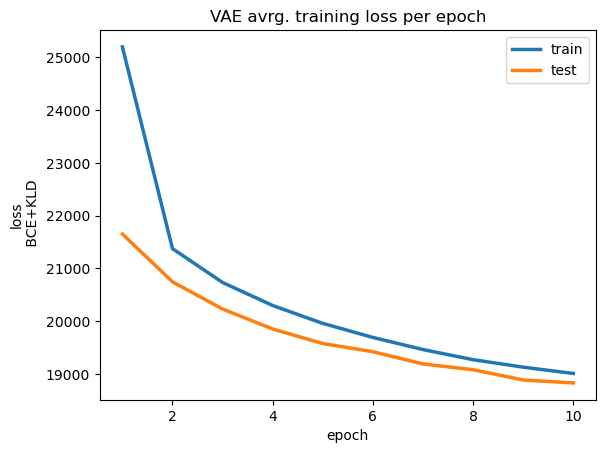

In [26]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [27]:
# encode entries
latent_coordinates = []
for data in train_data:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)


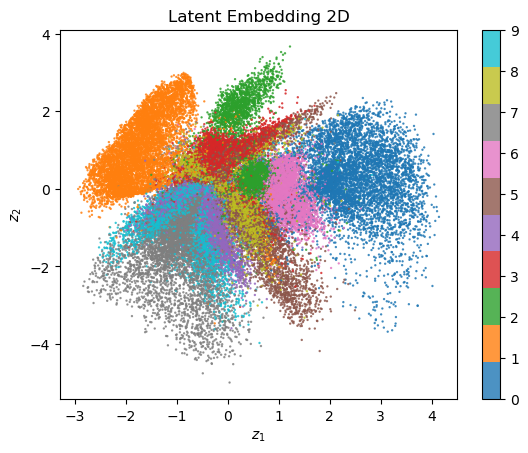

In [28]:
# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

Compared to the PPCA we obtain better spatial separation. 
Numbers of the same label are grouped together in coherent clusters.


The architecture is modified by introducing another hidden layer in the encoder and decoder.

### Visualization by Gauss CDF

In [30]:
## 2.) visualize across Gaussian CDF
n_cols = 12
z_space = torch.linspace(0.0001, 0.9999, n_cols) # for 5x5 grid
std_gauss = torch.distributions.normal.Normal(0, 1)

xx, yy = torch.meshgrid(z_space, z_space)

zz_gauss_cdf_vals = torch.dstack([std_gauss.icdf(xx), std_gauss.icdf(yy)]).reshape(-1, 2)
zz_gauss_cdf_vals.shape

/Users/rcml/miniforge3/envs/pml22/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1670076272106/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([144, 2])

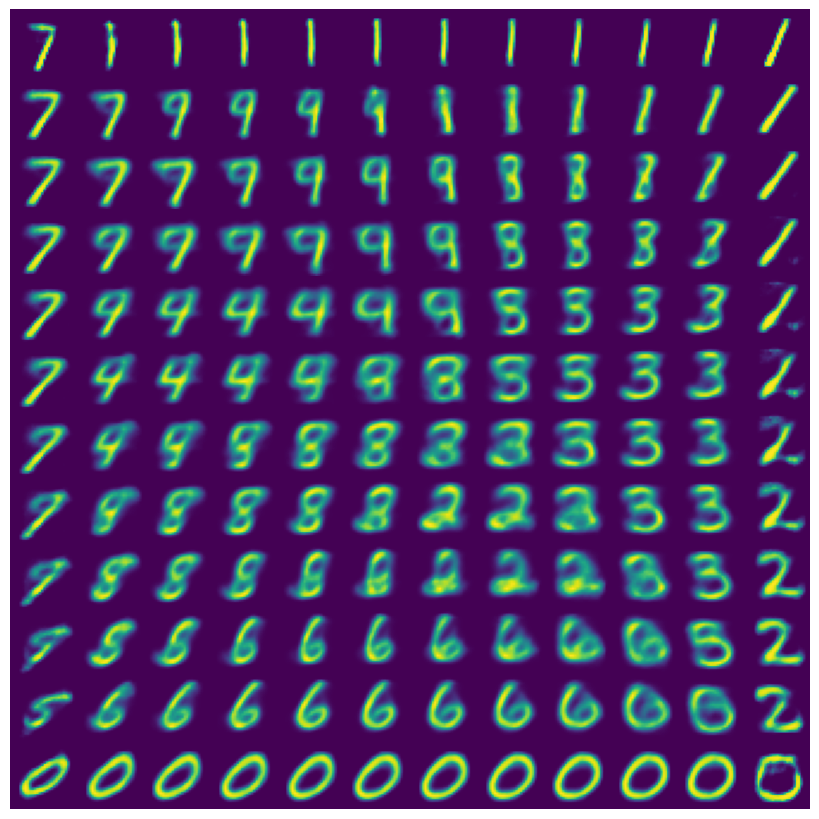

In [31]:
fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))

k = 0
for i in range(n_cols):
    for j in range(n_cols):
        _zz = zz_gauss_cdf_vals[k]
        reconstruction = model.decode(_zz.to(DEVICE)).cpu().detach().numpy()
        img = reconstruction.reshape((28,28))
        ax[i, j].imshow(img)
        ax[i, j].set_axis_off()
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k += 1
# plt.suptitle("MNIST reconstruction")
plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.show()


### DDPMs

#### Theory

For $t_1 < t_2 < t_3$:

The covariance matrix for $(X_{t_2}, X_{t_1}, X_{t_3})^T$ is

$
\begin{bmatrix}
1 & \exp(-\frac{1}{2}|t_1-t_2|) & \exp(-\frac{1}{2}|t_1-t_3|) \\
\exp(-\frac{1}{2}|t_1-t_2|) & 1 & \exp(-\frac{1}{2}|t_2-t_3|)  \\
\exp(-\frac{1}{2}|t_1-t_3|) & \exp(-\frac{1}{2}|t_2-t_3|) & 1  \\
\end{bmatrix}
$

By equation 29 in the lecture notes we get that the covariance matrix for $(X_{t_1}, X_{t_3})^T|X_{t_2}$ is

$
\begin{bmatrix}
1-\exp(-|t_1-t2|) & 0 \\
0 & 1-\exp(-|t_2-t_1|) \\
\end{bmatrix}
$

As $(X_{t_1}, X_{t_3})^T|X_{t_2}$ is Normal distributed and has 0's in the off diagonal of its covariance matrix, $X_{t_1} \amalg X_{t_3}|X_{t_2}$ for $t_1 < t_2 < t_3$. Hence,

$P(X_{t_1}, X_{t_2}, X_{t_3}) = P(X_{t_1})P(X_{t_2}|X_{t_1})P(X_{t_3}|X_{t_2}) = P(X_{t_2},X_{t_1})P(X_{t_3}|X_{t_2})$

The rest follows by an induction argument.

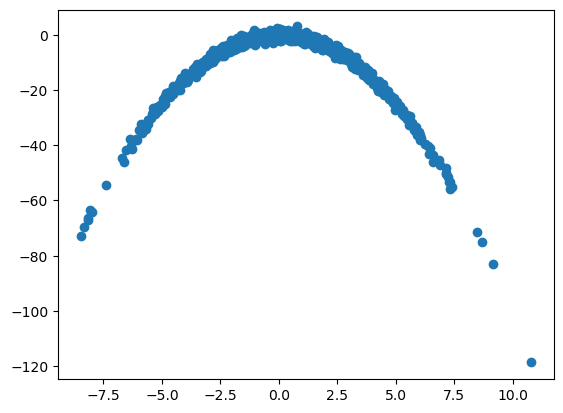

In [32]:
## using the provided notebook here
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#target distribution q_D
N=1000
Xs = np.random.randn(2*N).reshape(N,2)
Xs[:,0]*=3
Xs[:,1]+= -Xs[:,0]**2

plt.figure()
plt.scatter(Xs[:,0],Xs[:,1])
plt.show()

In [33]:
#neural network to learn epsilon(x_t,t). you can pla around with it, but we added it for convenience

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fct = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x,t):
        #we use a time-embedding here. neural networks are terrible at working directly with time as a real variable.
        #we therefore replace it by a set of features t_embedding that just represent several sine waves with different
        #frequency
        omegas = 2*np.pi*torch.tensor([1.0/T,2.0/T,4.0/T,8.0/T]).reshape(1,-1)
        t_embedding = torch.cos(omegas*t.reshape(-1,1))
        #Network structure: a simple network with two hidden layers. the first
        # two fully connected laers are just there to merge the time embedding with the input vector
        x = F.relu(self.fc1(x)+self.fct(t_embedding))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
def exp_f(x,y): return np.exp(-np.abs(x-y))

betas_b = np.array(list(map(lambda x: exp_f(x[0],x[1]), zip(np.arange(1,101), np.arange(0,100)))))
betas_b[1:10]

def compute_alpha_bar(t): # alternative alpha formulation
    return (1-0.05)**t

In [35]:
#Task 1: for the given set of T and beta plot the generating distribution q(X_t) for different t=0,30,60,100
T=100
betas = 0.05*np.ones(T)

alphas = np.exp(np.cumsum(np.log(1-betas))) # c.f. Eq. 70 in script

Text(0.5, 1.0, 'Alphas over t')

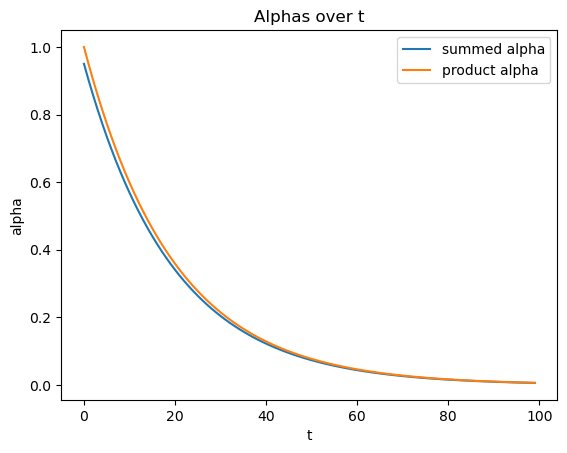

In [36]:
plt.plot(alphas, label="summed alpha")
plt.plot(list(map(compute_alpha_bar, np.arange(0, 100))), label="product alpha")
plt.ylabel("alpha")
plt.xlabel("t")
plt.legend()
plt.title("Alphas over t")

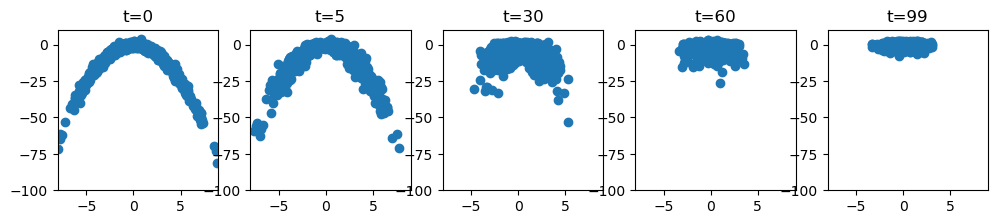

In [44]:
noise_results = []
ts = [0, T//20, int(T//3.3), int(T//1.65), T-1]
for a in alphas[ts]:
    x_noise = np.sqrt(a)*Xs + np.sqrt(1-a)*np.random.randn(2*N).reshape(N,2)
    noise_results.append(x_noise)

fig, ax = plt.subplots(1, 5, figsize=(12, 6))
for i, res in enumerate(noise_results):
    ax[i].scatter(res[:, 0], res[:, 1])
    ax[i].set_title(f"t={ts[i]}")
    ax[i].set_box_aspect(1)
    ax[i].set_xlim((-8, 9))
    ax[i].set_ylim((-100, 10))

plt.show()

In [45]:
#Task 2: implement the loss function for gradient descent (eq 76 in th script, or L_simple in the background material)
#implement by sampling a random time step t in 0,..,T
#params: 
#    Xs: a batch of samples from the dataset.
#    model: the model for learning epsilon.
def loss (Xs, model, T=T, alphas=alphas):
    ts = torch.randint(T, size=(Xs.shape[0],)) # pick t uniformly at random
    alpha = torch.tensor(alphas)[ts].reshape(-1,1)
    epsilon = torch.normal(0., 1., size=Xs.shape)
    samples = torch.sqrt(alpha)*Xs + torch.sqrt(1-alpha)*epsilon
    eps_model = model.forward(samples.type(torch.float32), ts)
    loss = torch.sum((epsilon-eps_model)**2)/Xs.shape[0] # Normalization not contained in Eq.76
    return loss

In [50]:
#train loop. added for your convenience.
train_loader = torch.utils.data.DataLoader(torch.tensor(Xs,dtype=torch.float32), batch_size=10)
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
num_epochs = 500
for e in range(num_epochs):
    if e % (num_epochs//10) == 0:
        print("epoch:",e)
    for data in train_loader:
        optimizer.zero_grad()
        l = loss(data,model) 
        l.backward()
        optimizer.step()

epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
epoch: 450


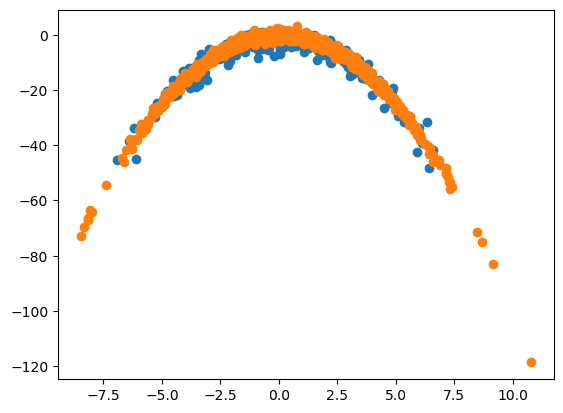

In [51]:
#Task 3: generate samples from the learned model
#num: number of samples to generate
#model: the trained model
def generate_samples(model, num: int, alphas: np.ndarray=alphas) -> torch.Tensor:
    Xs =  torch.normal(0.0, 1.0, size=(num,2), dtype=torch.float32)
    for t in reversed(range(T)):
        alpha = torch.tensor(alphas)[t]
        beta = torch.tensor(betas)[t]
        eps_model = model(Xs, t*torch.ones(num))
        std_model = beta / torch.sqrt(1-alpha)
        mu = (Xs-eps_model*std_model) / torch.sqrt(1-beta)
        Xs = mu + torch.normal(0., 1., size=(num, 2)) * torch.sqrt(beta)
    return Xs
samples = generate_samples(model,500).detach().numpy()

plt.figure()
plt.scatter(samples[:,0],samples[:,1])
plt.scatter(Xs[:,0],Xs[:,1])
plt.show()